In [1]:
from torchvision.datasets import ImageFolder
import torch.utils.data as Data
import torchvision.transforms as transforms
import time # 导入模块
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np

In [2]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )
        self.block5 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=384*3*3, out_features=4096),
            nn.ReLU(inplace=True)
        )
        self.block6 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True)
        )
        self.block7 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=num_classes)
        )
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
#         print(x.size())
        x = x.view(x.size(0), 384*3*3)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        return x

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
])
BATCH_SIZE = 128
train_dataset = ImageFolder("vehicle_dataset_new/training_dataset",transform = data_transform)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = ImageFolder("vehicle_dataset_new/test_dataset",transform = data_transform)
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_dataset))
print(len(test_dataset))
print(train_dataset[0][0].size())
print(train_dataset.class_to_idx)
print(test_dataset[0][0].size())
print(test_dataset.class_to_idx)

962
340
torch.Size([3, 64, 64])
{'bus': 0, 'car': 1, 'truck': 2}
torch.Size([3, 64, 64])
{'bus': 0, 'car': 1, 'truck': 2}


In [4]:
def train_epoch(net, data_loader, device):
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0

    for batch_idx, (data, target) in enumerate(data_loader):
        # print(data)
        # print(target)
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output, 1)
#         print("output", output)
#         print("prediction", prediction)
#         print("target", target)
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [5]:
num_classes = 3
epochs = 20
lr = 0.001
device = torch.device('cpu')
# device = torch.device('cuda')

net = AlexNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
training_time_list = []
for epoch in range(epochs):
    print("开始训练------" + str(epoch) + "-------------")

    start = time.time()  #开始时间
    train_loss, train_acc = train_epoch(net, data_loader=train_loader, device=device)
    end = time.time()  #结束时间
    test_loss, test_acc = 0, 0
    test_loss, test_acc  = test_epoch(net, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    training_time_list.append(end - start)
    print(f"epoch:{epoch}\t train_loss:{train_loss:.4f} \t"
          f"train_acc: {train_acc:.4f} \t"
          f"test_loss: {test_loss:.4f} \t test_acc: {test_acc:.4f} \t training_time: {end-start:.2f}")

开始训练------0-------------
epoch:0	 train_loss:1.3050 	train_acc: 0.5499 	test_loss: 0.9503 	 test_acc: 0.5735 	 training_time: 11.53
开始训练------1-------------
epoch:1	 train_loss:0.9949 	train_acc: 0.5499 	test_loss: 0.8953 	 test_acc: 0.5735 	 training_time: 11.05
开始训练------2-------------
epoch:2	 train_loss:0.8330 	train_acc: 0.5884 	test_loss: 0.5996 	 test_acc: 0.7765 	 training_time: 15.08
开始训练------3-------------
epoch:3	 train_loss:0.5466 	train_acc: 0.7713 	test_loss: 0.4749 	 test_acc: 0.7706 	 training_time: 11.08
开始训练------4-------------
epoch:4	 train_loss:0.4066 	train_acc: 0.8191 	test_loss: 0.4079 	 test_acc: 0.8471 	 training_time: 11.19
开始训练------5-------------
epoch:5	 train_loss:0.3406 	train_acc: 0.8701 	test_loss: 0.4704 	 test_acc: 0.8029 	 training_time: 11.40
开始训练------6-------------
epoch:6	 train_loss:0.3626 	train_acc: 0.8472 	test_loss: 0.3351 	 test_acc: 0.8794 	 training_time: 10.98
开始训练------7-------------
epoch:7	 train_loss:0.2805 	train_acc: 0.8929 	test

In [6]:
for epoch in range(epochs):
    print("开始训练------" + str(20 + epoch) + "-------------")

    start = time.time()  #开始时间
    train_loss, train_acc = train_epoch(net, data_loader=train_loader, device=device)
    end = time.time()  #结束时间
    test_loss, test_acc = 0, 0
    test_loss, test_acc  = test_epoch(net, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    training_time_list.append(end - start)
    print(f"epoch:{20 + epoch}\t train_loss:{train_loss:.4f} \t"
          f"train_acc: {train_acc:.4f} \t"
          f"test_loss: {test_loss:.4f} \t test_acc: {test_acc:.4f} \t training_time: {end-start:.2f}")

开始训练------20-------------
epoch:20	 train_loss:0.0929 	train_acc: 0.9657 	test_loss: 0.4661 	 test_acc: 0.9118 	 training_time: 11.05
开始训练------21-------------
epoch:21	 train_loss:0.0879 	train_acc: 0.9719 	test_loss: 0.2037 	 test_acc: 0.9118 	 training_time: 11.71
开始训练------22-------------
epoch:22	 train_loss:0.1033 	train_acc: 0.9667 	test_loss: 0.2128 	 test_acc: 0.9265 	 training_time: 11.02
开始训练------23-------------
epoch:23	 train_loss:0.0712 	train_acc: 0.9792 	test_loss: 0.1903 	 test_acc: 0.9206 	 training_time: 10.93
开始训练------24-------------
epoch:24	 train_loss:0.0695 	train_acc: 0.9740 	test_loss: 0.2427 	 test_acc: 0.9235 	 training_time: 11.02
开始训练------25-------------
epoch:25	 train_loss:0.0480 	train_acc: 0.9823 	test_loss: 0.3296 	 test_acc: 0.9029 	 training_time: 10.94
开始训练------26-------------
epoch:26	 train_loss:0.0674 	train_acc: 0.9751 	test_loss: 0.2475 	 test_acc: 0.9324 	 training_time: 10.88
开始训练------27-------------
epoch:27	 train_loss:0.0430 	train_a

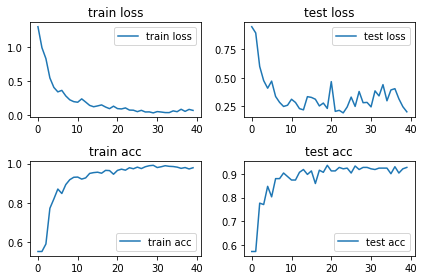

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot(train_loss_list,label,title, subplot):
    ax1 = plt.subplot(subplot)
    plt.plot(list(range(len(train_loss_list))),train_loss_list, label=label)
    ax1.set_title(title)
    ax1.legend()
#     plt.title(title)
#     plt.legend()
#     plt.show()
plot(train_loss_list,"train loss","train loss", 221)
plot(test_loss_list,"test loss","test loss", 222)
plot(train_acc_list,"train acc","train acc", 223)
plot(test_acc_list,"test acc","test acc", 224)
plt.tight_layout()
plt.show()
